In [3]:
!pip install opencv-python
!pip install numpy

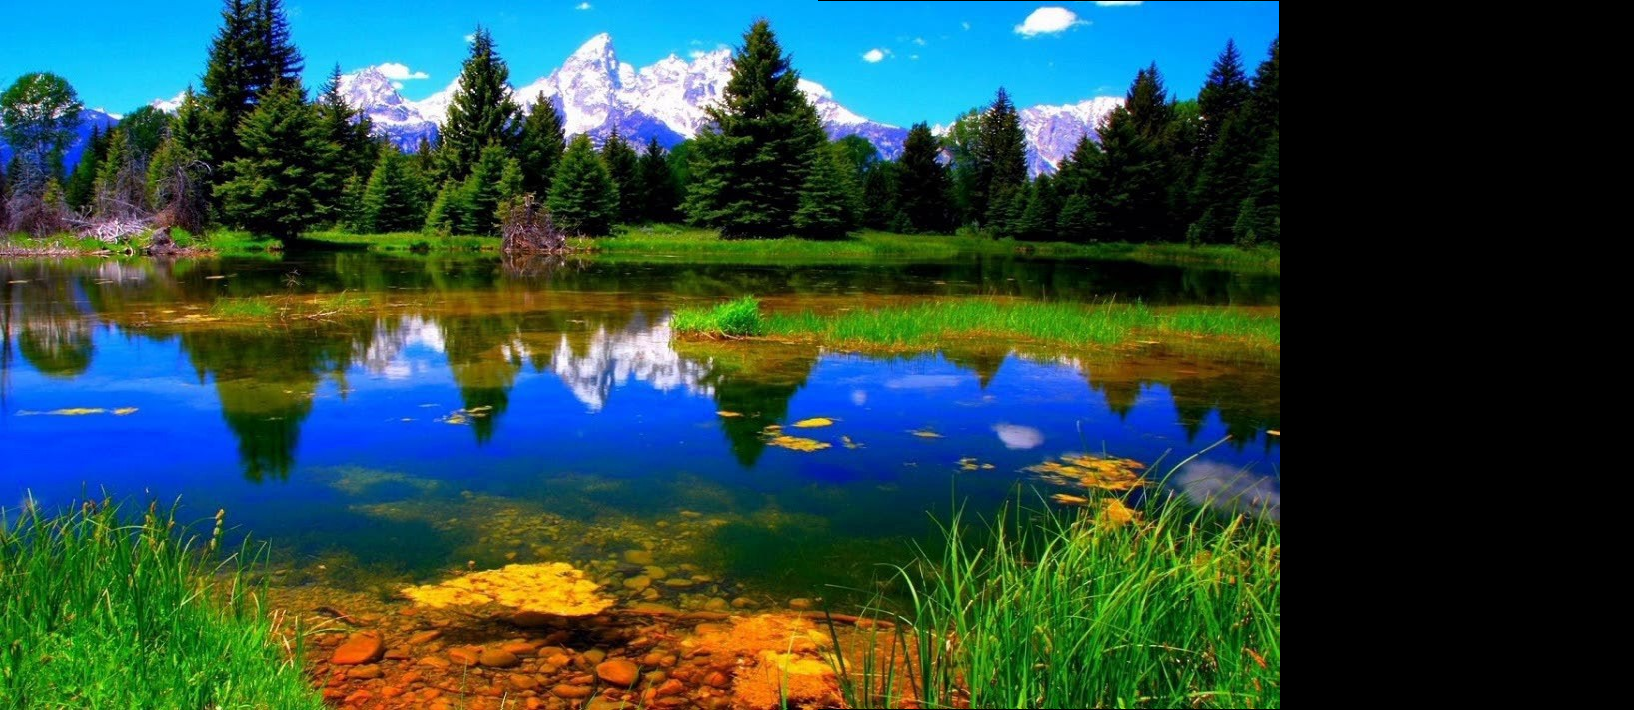

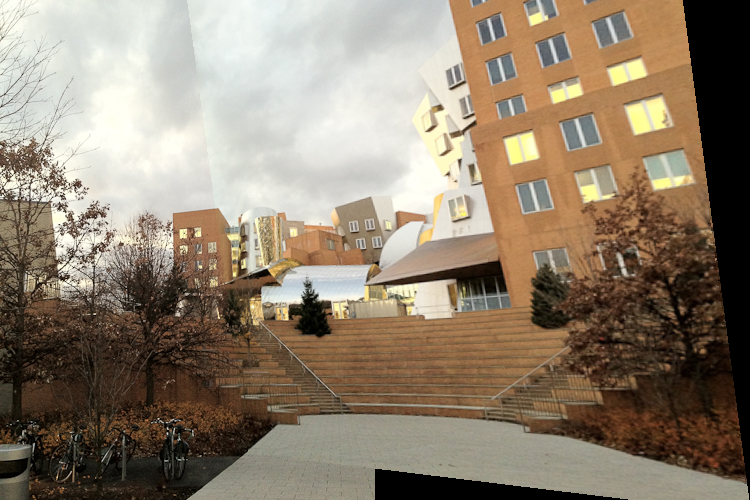

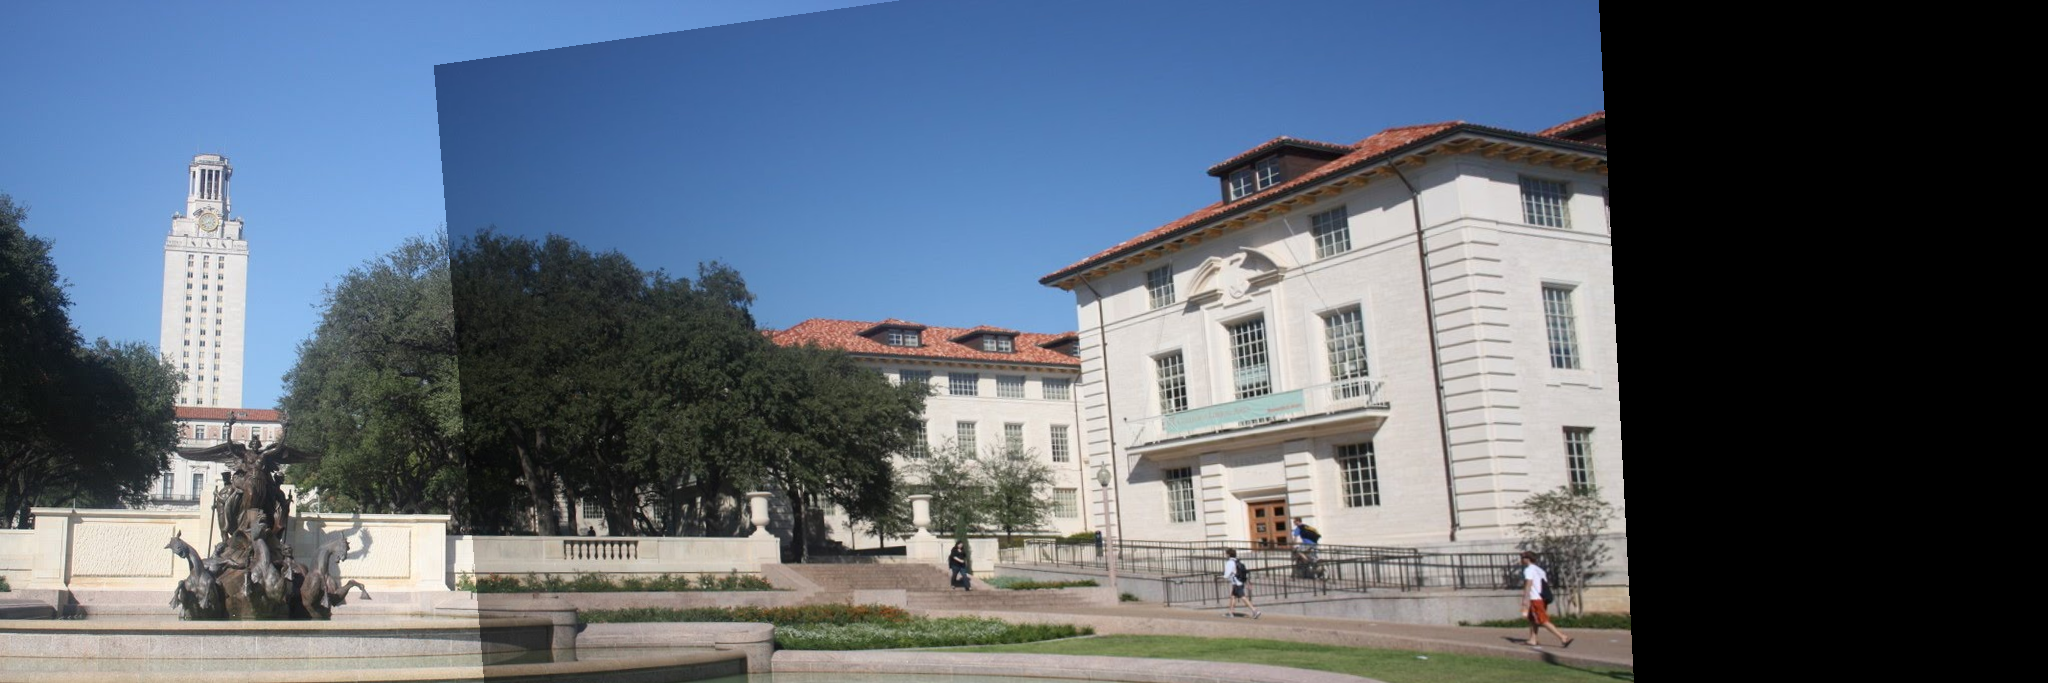

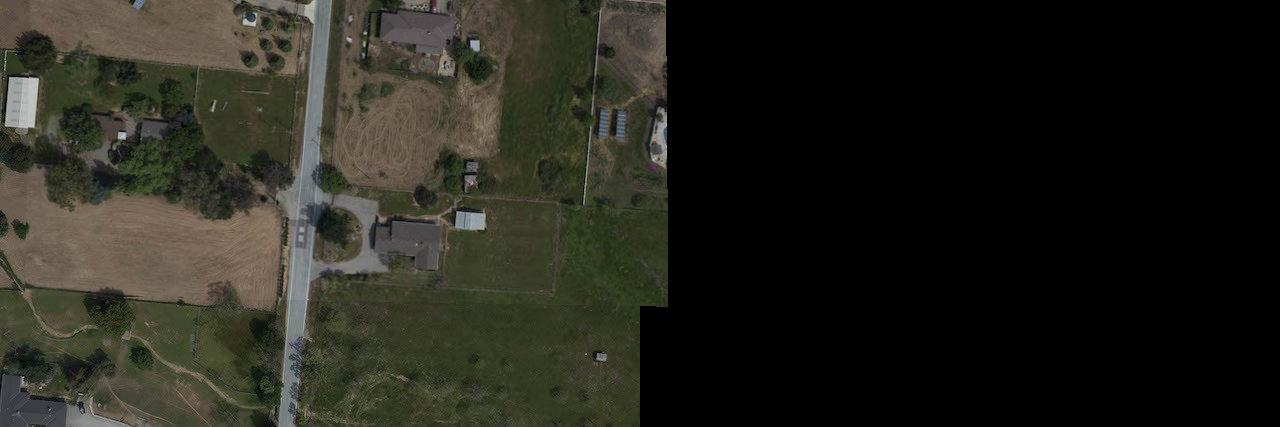

In [16]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Adaptive Non-Maximal Suppression
def anms(keypoints, num_ret_points):
    if len(keypoints) <= num_ret_points:
        return keypoints

    strengths = [-kp.response for kp in keypoints]
    keypoints_sorted = [kp for _,kp in sorted(zip(strengths, keypoints), key=lambda x: x[0])]
    return keypoints_sorted[:num_ret_points]

def stitch_images(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1 = sift.detect(gray1, None)
    kp2 = sift.detect(gray2, None)

    num_ret_points = 500
    kp1 = anms(kp1, num_ret_points)
    kp2 = anms(kp2, num_ret_points)

    _, des1 = sift.compute(gray1, kp1)
    _, des2 = sift.compute(gray2, kp2)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good = [m for m, n in matches if m.distance < 0.7 * n.distance]

    if len(good) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h1, w1 = img1.shape[:2]
        h2, w2 = img2.shape[:2]

        panorama_height = max(h1, h2)
        panorama_width = w1 + w2

        img_warp = np.zeros((panorama_height, panorama_width, 3), dtype=img1.dtype)
        img_warp[0:h2, 0:w2] = img2
        img_warp = cv2.warpPerspective(img1, H, (panorama_width, panorama_height), img_warp, borderMode=cv2.BORDER_TRANSPARENT)

        return img_warp
    else:
        raise ValueError("Not enough matches are found - {}/{}".format(len(good), 10))

image_pairs = [
    ("image pairs_01_02.jpg", "image pairs_01_01.jpg"),
    ("image pairs_02_01.png", "image pairs_02_02.png"),
    ("image pairs_03_02.jpg", "image pairs_03_01.jpg"),
    ("image pairs_04_01.jpg", "image pairs_04_02.jpg")
]

results = []

for idx, (img1_path, img2_path) in enumerate(image_pairs, 1):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    result = stitch_images(img1, img2)
    results.append(result)

    if result is not None:
        filename = f"stitched_image{idx}.jpg"
        cv2.imwrite(filename, result)
        cv2_imshow(result)
    else:
        print(f"Not enough matches to stitch image pair {idx}.")